# Imports

In [138]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import re
import matplotlib.pyplot as plt
import seaborn as sns

In [139]:
train = pd.read_csv('shelter-animal-outcomes/train.csv.gz')
test  = pd.read_csv('shelter-animal-outcomes/test.csv.gz')

In [140]:
# pythonize columns
train.columns = [col.lower() for col in train.columns]
test.columns = [col.lower() for col in test.columns]

# Target

In [141]:
train.outcometype.value_counts(normalize=True)

Adoption           0.402896
Transfer           0.352501
Return_to_owner    0.179056
Euthanasia         0.058177
Died               0.007370
Name: outcometype, dtype: float64

Our target variable is `outcometype` that has a baseline score of 40.2%

# EDA

## Examine Nulls

In [142]:
train.isnull().sum().to_frame().sort_values(0,ascending=False)

,0
outcomesubtype,13612
name,7691
ageuponoutcome,18
sexuponoutcome,1
animalid,0
datetime,0
outcometype,0
animaltype,0
breed,0
color,0


Outcomesubtype is an extension of outcometype and is out of scope for this analysis. Drop it

In [143]:
train.drop('outcomesubtype', axis=1, inplace=True)

Name can be converted to a boolean has_name

In [144]:
train['has_name'] = train.name.map(lambda x: 0 if pd.isnull(x) else 1)
test['has_name'] = test.name.map(lambda x: 0 if pd.isnull(x) else 1)

train.drop('name', axis=1, inplace=True)
test.drop('name', axis=1, inplace=True)

In [145]:
# useful graph functions

def distgraph(var, var_order, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    (train.groupby('outcometype')[var].value_counts()\
                                    .unstack().T.loc[var_order].sum(axis=1)\
                                 /train.shape[0])\
                    .plot(kind='barh')
    
    # fluff
    ax.set_xlabel('Percentage')
    ax.set_title(title+'\n\nDistribution',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
   
    max_width = 0
    for rect in ax.patches:
        if rect.get_width()>max_width:
            max_width = rect.get_width()
    
    for rect in ax.patches:

            height = rect.get_height()
            width = rect.get_width()
            x = rect.get_x()
            y = rect.get_y()
            
            label_text = round(width, 2)
            
            label_x = x + width / 2
            label_y = y + height / 2

            if label_x < max_width*.05:
                ax.text(width+.05*max_width, label_y, f'{label_text:.2f}'
                        , ha='center', va='center', color = 'black')
            else:
                ax.text(label_x, label_y, f'{label_text:.2f}'
                        , ha='center', va='center', color = 'white')
            
    
    ax.set(ylabel=None);

def propgraph(var,var_order,title):
    fig, ax = plt.subplots()

    train.groupby(var)['outcometype'].value_counts(normalize=True)\
        .unstack().loc[var_order].T\
        .loc[['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']].T\
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'darkorange', 'forestgreen', 'cornflowerblue', 'tomato'], 
              ax=ax)
    ax.set_title(title+'\n\nProportion of Animal Outcome',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(None)
    ax.legend(loc=(1.05,0.88))
    
    max_width = 0
    for rect in ax.patches:
        if rect.get_width()>max_width:
            max_width = rect.get_width()
    
    for rect in ax.patches:

            height = rect.get_height()
            width = rect.get_width()
            x = rect.get_x()
            y = rect.get_y()
            
            label_text = round(width, 2)
            
            label_x = x + width / 2
            label_y = y + height / 2

            if label_x >= max_width*.05:
                ax.text(label_x, label_y, f'{label_text:.2f}'
                        , ha='center', va='center', color = 'black')

In [146]:
def age_to_years(item):
    # convert item to list if it is one string
    if type(item) is str:
        item = [item]
    ages_in_years = np.zeros(len(item))
    for i in range(len(item)):
        # check if item[i] is str
        if type(item[i]) is str:
            if 'day' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])/365
            if 'week' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])/52.1429
            if 'month' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])/12
            if 'year' in item[i]:
                ages_in_years[i] = int(item[i].split(' ')[0])
        else:
            # item[i] is not a string but a nan
            ages_in_years[i] = 0
    return ages_in_years
train['ageuponoutcome'] = age_to_years(train['ageuponoutcome']).round(2)
test['ageuponoutcome'] = age_to_years(test['ageuponoutcome']).round(2)

In [147]:
age_category_train = pd.cut(train.ageuponoutcome,
            bins=[0, 0.5, 1.0,
               10.0, 20.0],
            labels=['baby',
                    'young',
                    'adolescent',
                    'old'])

train['age_category'] = age_category_train

age_category_test = pd.cut(test.ageuponoutcome,
            bins=[0, 0.5, 1.0,
               10.0, 20.0],
            labels=['baby',
                    'young',
                    'adolescent',
                    'old'])

test['age_category'] = age_category_test


In [148]:
# train = train[~(train.ageuponoutcome.isnull()) & ~(train.sexuponoutcome.isnull())]

<AxesSubplot:xlabel='breed'>

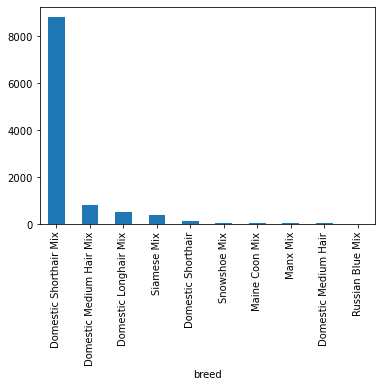

In [149]:
train[train.animaltype=='Cat'].groupby('breed').count().animalid.sort_values(ascending=False)[:10].plot(kind='bar')

<AxesSubplot:xlabel='breed'>

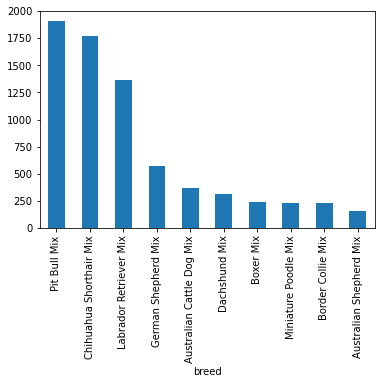

In [150]:
train[train.animaltype=='Dog'].groupby('breed').count().animalid.sort_values(ascending=False)[:10].plot(kind='bar')

In [151]:
# remove domestic from breed
train.breed = train.breed.map(lambda x: x.lower().replace('domestic',''))
test.breed = test.breed.map(lambda x: x.lower().replace('domestic',''))

In [152]:
# remove and encode mix
train['is_mix'] = train.breed.map(lambda x: ' mix' in x.lower()
                                            or '/' in x).astype(int)
train.breed = train.breed.map(lambda x: x.lower().replace(' mix','').replace(' ',''))
train.breed = train['breed'].str.split('/').map(lambda x: x[0])


test['is_mix'] = test.breed.map(lambda x: ' mix' in x.lower()
                                          or '/' in x).astype(int)
test.breed = test.breed.map(lambda x: x.lower().replace(' mix','').replace(' ',''))
test.breed = test['breed'].str.split('/').map(lambda x: x[0])

<AxesSubplot:xlabel='breed'>

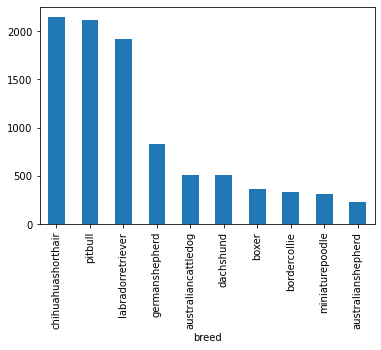

In [153]:
train[train.animaltype=='Dog'].groupby('breed').count().animalid.sort_values(ascending=False)[:10].plot(kind='bar')

In [154]:
# add cat breeds
train= train.join(pd.get_dummies(
        train.apply(lambda x: '' if x.animaltype=='Dog' else x.breed, axis=1),
        prefix='cat_breed')\
        [['cat_breed_shorthair','cat_breed_mediumhair',
          'cat_breed_longhair','cat_breed_siamese']])

test= test.join(pd.get_dummies(
        test.apply(lambda x: '' if x.animaltype=='Dog' else x.breed, axis=1),
        prefix='cat_breed')\
        [['cat_breed_shorthair','cat_breed_mediumhair',
          'cat_breed_longhair','cat_breed_siamese']])

In [155]:
train[train.animaltype=='Dog'].breed.value_counts(normalize=True)[:10]

chihuahuashorthair     0.137544
pitbull                0.135492
labradorretriever      0.122796
germanshepherd         0.052966
australiancattledog    0.032767
dachshund              0.032703
boxer                  0.023084
bordercollie           0.021417
miniaturepoodle        0.019878
australianshepherd     0.014684
Name: breed, dtype: float64

In [156]:
# create helper columns
train['dog_breed'] = train.apply(lambda x:
                                 '' if x.animaltype=='Cat' 
                                 else x.breed, axis=1)

test['dog_breed'] = train.apply(lambda x:
                                 '' if x.animaltype=='Cat' 
                                 else x.breed, axis=1)

In [157]:
train['dog_breed'] = train.apply(lambda x:'chihuahua' if 'chihuahua' in x.dog_breed 
                                     else x.dog_breed, axis=1)

train['dog_breed'] = train.apply(lambda x:'pitbull' if 'pitbull' in x.dog_breed 
                                     else x.dog_breed, axis=1)

train['dog_breed'] = train.apply(lambda x:'labrador' if 'labrador' in x.dog_breed 
                                     else x.dog_breed, axis=1)

train['dog_breed'] = train.apply(lambda x:'shepherd' if 'shepherd' in x.dog_breed 
                                     else x.dog_breed, axis=1)

train = train.join(pd.get_dummies(train.dog_breed, prefix='dog_breed')\
                    [['dog_breed_chihuahua','dog_breed_pitbull',
                     'dog_breed_labrador','dog_breed_shepherd']])

train['dog_breed'] = train.apply(lambda x:'other' if x.dog_breed not in ['chihuahua','pitbull','labrador','shepherd','']
                                 else x.dog_breed, axis=1)

# train.drop('dog_breed', axis=1, inplace=True)
# train['dog_breed'] = train.apply(lambda x:'poodle' if 'poodle' in x.dog_breed 
#                                      else x.dog_breed, axis=1)

# train['dog_breed'] = train.apply(lambda x:'collie' if 'collie' in x.dog_breed 
#                                      else x.dog_breed, axis=1)

# train['dog_breed'] = train.apply(lambda x:'terrier' if 'terrier' in x.dog_breed 
#                                      else x.dog_breed, axis=1)

<AxesSubplot:xlabel='dog_breed'>

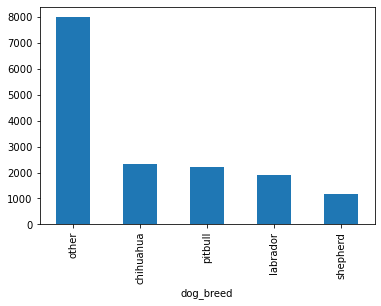

In [158]:
train[train.dog_breed != ''].groupby('dog_breed').count().animalid.sort_values(ascending=False)[:10].plot(kind='bar')

In [159]:
train.drop('dog_breed', axis=1, inplace=True)

In [160]:
test['dog_breed'] = test.apply(lambda x:'chihuahua' if 'chihuahua' in x.dog_breed 
                                     else x.dog_breed, axis=1)

test['dog_breed'] = test.apply(lambda x:'pitbull' if 'pitbull' in x.dog_breed 
                                     else x.dog_breed, axis=1)

test['dog_breed'] = test.apply(lambda x:'labrador' if 'labrador' in x.dog_breed 
                                     else x.dog_breed, axis=1)

test['dog_breed'] = test.apply(lambda x:'shepherd' if 'shepherd' in x.dog_breed 
                                     else x.dog_breed, axis=1)

test = test.join(pd.get_dummies(test.dog_breed, prefix='dog_breed')\
                    [['dog_breed_chihuahua','dog_breed_pitbull',
                     'dog_breed_labrador','dog_breed_shepherd']])

test.drop('dog_breed', axis=1, inplace=True)

In [161]:
# drop breed
train.drop('breed', axis=1, inplace=True)
test.drop('breed', axis=1, inplace=True)

In [162]:
color_lst = []
for x in train['color']:
    pattern = r'\W+'
    color_lst.append(re.split(pattern, x))

color_df = pd.DataFrame(color_lst)
color_df.columns=['primary_color', 'secondary_color', 'tertiary_color', 'other']

In [163]:
for i, v in enumerate(color_df['primary_color']):
    if v == 'Red':
        color_df['primary_color'][i] ='Orange'
    elif v == 'Tortie':
        color_df['primary_color'][i] ='Tricolor'
    elif v == 'Calico':
        color_df['primary_color'][i] ='Tricolor'
    elif v == 'Torbie':
        color_df['primary_color'][i] ='Tricolor'
    elif v == 'Sable':
        color_df['primary_color'][i] ='Tan'
    elif v == 'Cream':
        color_df['primary_color'][i] ='Tan'
    elif v == 'Chocolate':
        color_df['primary_color'][i] ='Brown'
    elif v == 'Gray':
        color_df['primary_color'][i] ='Gray'
    elif v in ['Buff', 'Yellow' , 'Fawn' , 'Lynx' ,\
              'Seal' , 'Silver' , 'Flame' , 'Gold' ,\
              'Lilac' , 'Apricot' , 'Liver' , 'Agouti' ,\
              'Pink' , 'Ruddy']:
        color_df['primary_color'][i] = 'Other'

In [164]:
train = train.join(color_df['primary_color'])

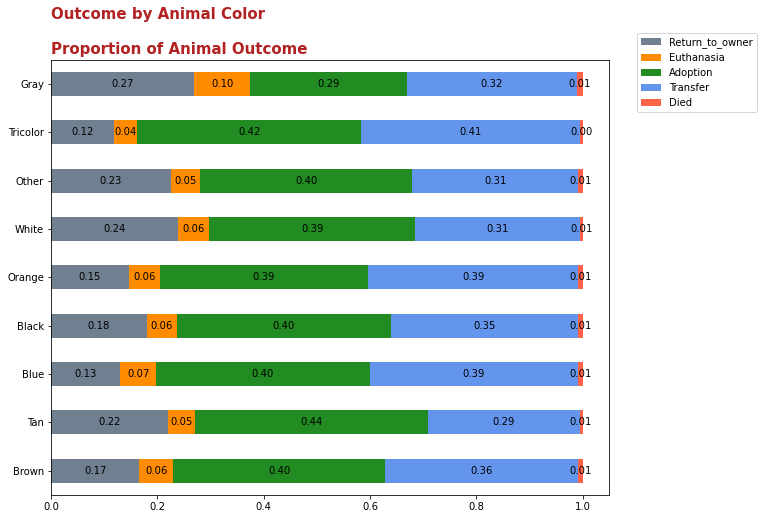

In [165]:
propgraph(color_df['primary_color'], color_df['primary_color'].unique(), 'Outcome by Animal Color')

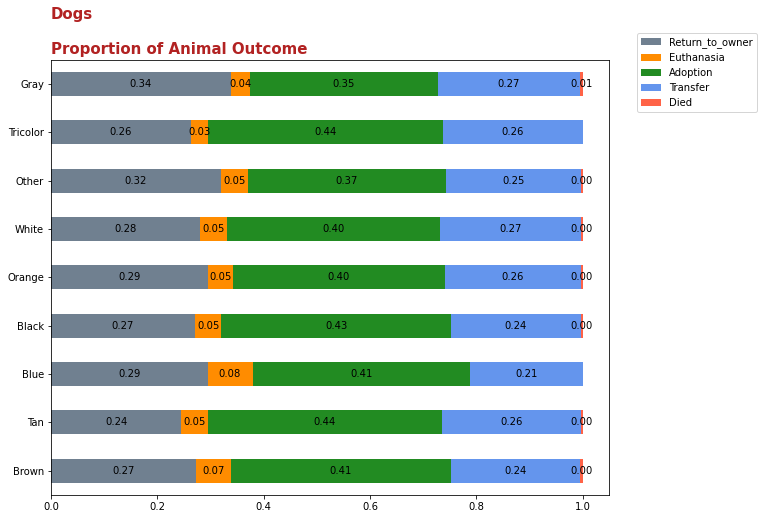

In [166]:

fig, ax = plt.subplots()

train[train.animaltype=='Dog'].groupby('primary_color')['outcometype'].value_counts(normalize=True)\
    .unstack().loc[train['primary_color'].unique()].T\
    .loc[['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']].T\
    .plot(kind='barh', 
          figsize=(10, 8), 
          stacked=True,
          color=['slategrey', 'darkorange', 'forestgreen', 'cornflowerblue', 'tomato'], 
          ax=ax)
ax.set_title('Dogs''\n\nProportion of Animal Outcome',
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left')
ax.set_ylabel(None)
ax.legend(loc=(1.05,0.88))

max_width = 0
for rect in ax.patches:
    if rect.get_width()>max_width:
        max_width = rect.get_width()

for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2

        if label_x >= max_width*.05:
            ax.text(label_x, label_y, f'{label_text:.2f}'
                    , ha='center', va='center', color = 'black')

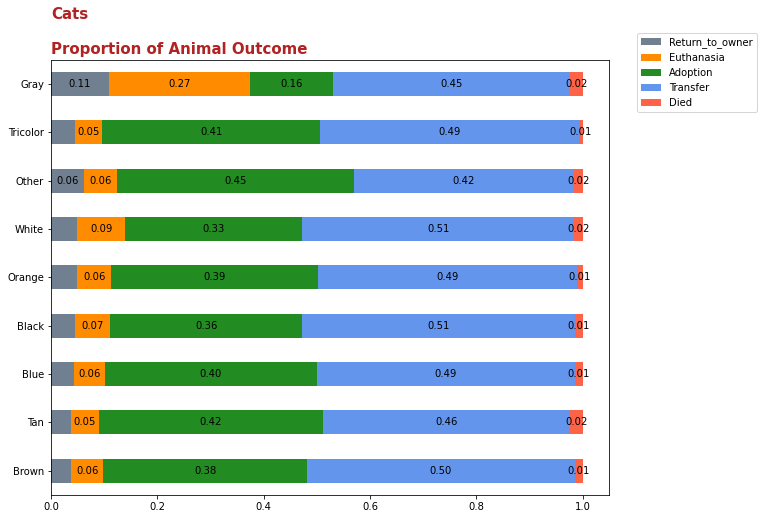

In [167]:

fig, ax = plt.subplots()

train[train.animaltype=='Cat'].groupby('primary_color')['outcometype'].value_counts(normalize=True)\
    .unstack().loc[train['primary_color'].unique()].T\
    .loc[['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']].T\
    .plot(kind='barh', 
          figsize=(10, 8), 
          stacked=True,
          color=['slategrey', 'darkorange', 'forestgreen', 'cornflowerblue', 'tomato'], 
          ax=ax)
ax.set_title('Cats'+'\n\nProportion of Animal Outcome',
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left')
ax.set_ylabel(None)
ax.legend(loc=(1.05,0.88))

max_width = 0
for rect in ax.patches:
    if rect.get_width()>max_width:
        max_width = rect.get_width()

for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2

        if label_x >= max_width*.05:
            ax.text(label_x, label_y, f'{label_text:.2f}'
                    , ha='center', va='center', color = 'black')

In [168]:
color_df

,primary_color,secondary_color,tertiary_color,other
0,Brown,White,None,None
1,Tan,Tabby,None,None
2,Blue,White,None,None
3,Blue,Cream,None,None
4,Tan,None,None,None
...,...,...,...,...
26724,Brown,Tabby,White,None
26725,Brown,Tabby,None,None
26726,White,Tan,None,None
26727,Black,None,None,None


In [169]:
color_lst = []
for x in test['color']:
    pattern = r'\W+'
    color_lst.append(re.split(pattern, x))

color_df = pd.DataFrame(color_lst)
color_df.columns=['primary_color', 'secondary_color', 'tertiary_color', 'other']

In [170]:
for i, v in enumerate(color_df['primary_color']):
    if v == 'Red':
        color_df['primary_color'][i] ='Orange'
    elif v == 'Tortie':
        color_df['primary_color'][i] ='Tricolor'
    elif v == 'Calico':
        color_df['primary_color'][i] ='Tricolor'
    elif v == 'Torbie':
        color_df['primary_color'][i] ='Tricolor'
    elif v == 'Sable':
        color_df['primary_color'][i] ='Tan'
    elif v == 'Cream':
        color_df['primary_color'][i] ='Tan'
    elif v == 'Chocolate':
        color_df['primary_color'][i] ='Brown'
    elif v == 'Gray':
        color_df['primary_color'][i] ='Gray'
    elif v in ['Buff', 'Yellow' , 'Fawn' , 'Lynx' ,\
              'Seal' , 'Silver' , 'Flame' , 'Gold' ,\
              'Lilac' , 'Apricot' , 'Liver' , 'Agouti' ,\
              'Pink' , 'Ruddy']:
        color_df['primary_color'][i] = 'Other'

In [171]:
test = test.join(color_df['primary_color'])

In [172]:
train.drop(['animalid','color'], axis=1, inplace=True)
test.drop(['color'], axis=1, inplace=True)

In [173]:
train = train[~(train.ageuponoutcome.isnull()) & ~(train.sexuponoutcome.isnull())]

In [177]:
train = train.join(pd.get_dummies(train.animaltype, drop_first=True))
train.drop('animaltype',axis=1,inplace=True)

test = test.join(pd.get_dummies(test.animaltype, drop_first=True))
test.drop('animaltype',axis=1,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'animaltype'

In [178]:
train.sexuponoutcome.value_counts(normalize=True)

Neutered Male    0.365871
Spayed Female    0.329991
Intact Male      0.131884
Intact Female    0.131360
Unknown          0.040893
Name: sexuponoutcome, dtype: float64

In [179]:
train['is_fixed'] = train.sexuponoutcome.map(lambda x: 1 if 'Neutered' in x
                                             or 'Spayed' in x
                                             else 0)
test['is_fixed'] = test.sexuponoutcome.map(lambda x: 1 if 'Neutered' in x
                                             or 'Spayed' in x
                                             else 0)

train['gender'] = train.sexuponoutcome.map(lambda x: 'male' if ' Male' in x
                                          else 'female' if 'Female' in x
                                          else 'unknown')
test['gender'] = test.sexuponoutcome.map(lambda x: 'male' if ' Male' in x
                                          else 'female' if 'Female' in x
                                          else 'unknown')

In [180]:
train = train.join(pd.get_dummies(train.gender)[['male','female']])

test = test.join(pd.get_dummies(test.gender)[['male','female']])

train.drop(['gender','sexuponoutcome'], axis=1, inplace=True)
test.drop(['gender','sexuponoutcome'], axis=1, inplace=True)

In [181]:
train = train.join(pd.get_dummies(train.age_category, prefix = 'age', drop_first=True))
test = test.join(pd.get_dummies(test.age_category, prefix = 'age', drop_first=True))

train.drop('age_category', axis=1, inplace=True)
test.drop('age_category', axis=1, inplace=True)

In [182]:
train = train.join(pd.get_dummies(train.primary_color, prefix = 'primary_color'))
train.drop(['primary_color', 'primary_color_Other'], axis=1, inplace=True)

test = test.join(pd.get_dummies(test.primary_color, prefix = 'primary_color'))
test.drop(['primary_color', 'primary_color_Other'], axis=1, inplace=True)

In [183]:
train['month'] = pd.to_datetime(train['datetime']).dt.strftime('%m')
test['month'] = pd.to_datetime(test['datetime']).dt.strftime('%m')

In [184]:
map_month ={'01':'Jan',
           '02':'Feb',
            '03':'March',
            '04':'April',
           '05':'May',
            '06':'June',
           '07':'July',
            '08':'Aug',
           '09':'Sept',
           '10':'Oct',
           '11':'Nov',
           '12':'Dec'}
train['month']=train['month'].map(map_month)
test['month']=test['month'].map(map_month)

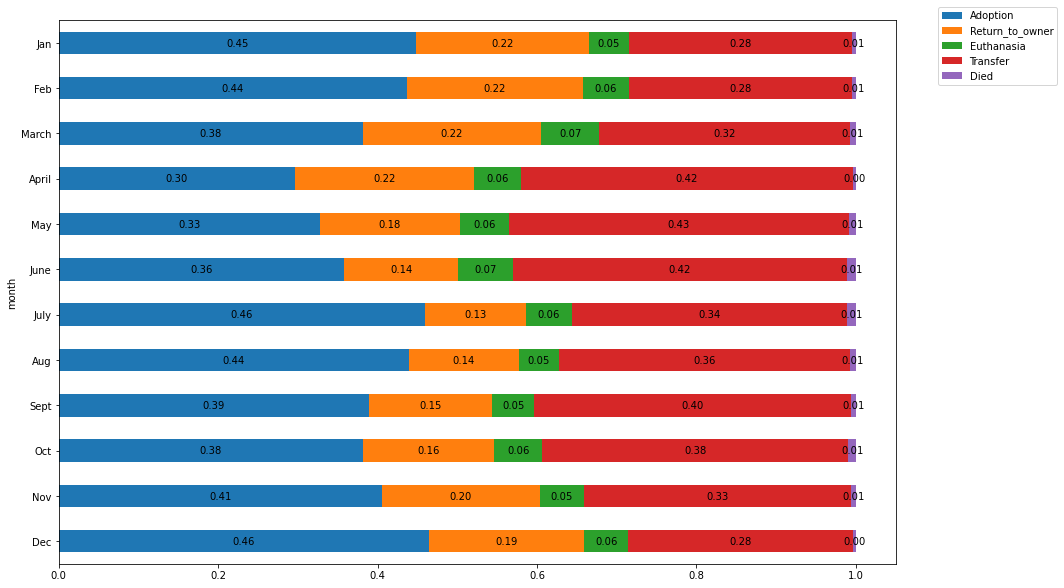

In [185]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
train.groupby('month').outcometype.value_counts(normalize=True).unstack()\
.loc[['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec'][::-1]].T\
.loc[['Adoption','Return_to_owner','Euthanasia','Transfer','Died']].T.plot(kind='barh', stacked=True, ax=ax)
ax.legend(loc=(1.05,0.88),labels=['Adoption','Return_to_owner','Euthanasia','Transfer','Died'])

for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2

        if label_x >= max_width*.05:
            ax.text(label_x, label_y, f'{label_text:.2f}'
                    , ha='center', va='center', color = 'black')

In [186]:
train.columns

Index(['datetime', 'outcometype', 'ageuponoutcome', 'has_name', 'is_mix',
       'cat_breed_shorthair', 'cat_breed_mediumhair', 'cat_breed_longhair',
       'cat_breed_siamese', 'dog_breed_chihuahua', 'dog_breed_pitbull',
       'dog_breed_labrador', 'dog_breed_shepherd', 'Dog', 'is_fixed', 'male',
       'female', 'age_young', 'age_adolescent', 'age_old',
       'primary_color_Black', 'primary_color_Blue', 'primary_color_Brown',
       'primary_color_Gray', 'primary_color_Orange', 'primary_color_Tan',
       'primary_color_Tricolor', 'primary_color_White', 'month'],
      dtype='object')

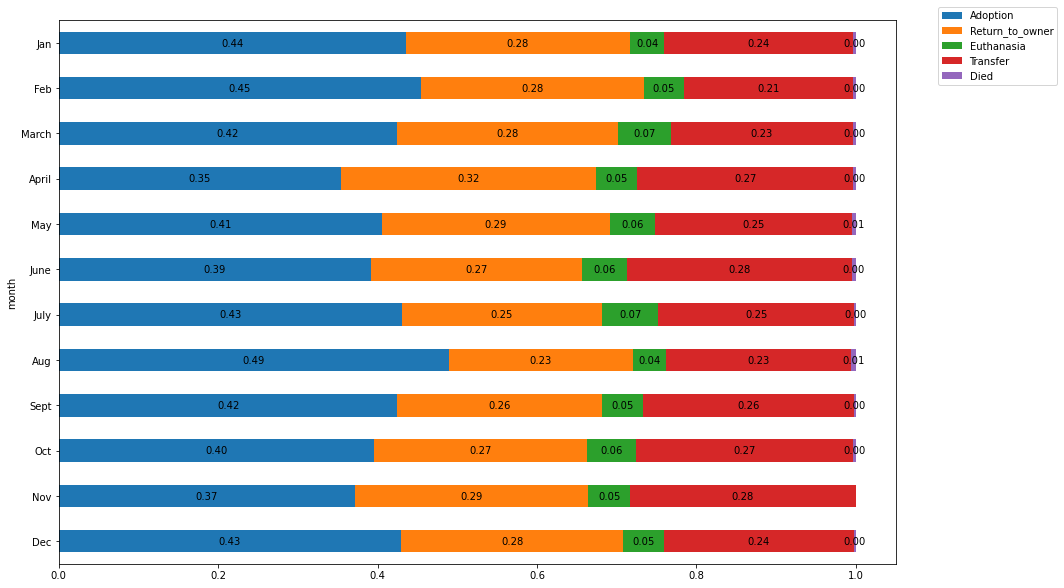

In [189]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
train[train.Dog==1].groupby('month').outcometype.value_counts(normalize=True).unstack()\
.loc[['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec'][::-1]].T\
.loc[['Adoption','Return_to_owner','Euthanasia','Transfer','Died']].T.plot(kind='barh', stacked=True, ax=ax)
ax.legend(loc=(1.05,0.88),labels=['Adoption','Return_to_owner','Euthanasia','Transfer','Died'])

for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2

        if label_x >= max_width*.05:
            ax.text(label_x, label_y, f'{label_text:.2f}'
                    , ha='center', va='center', color = 'black')

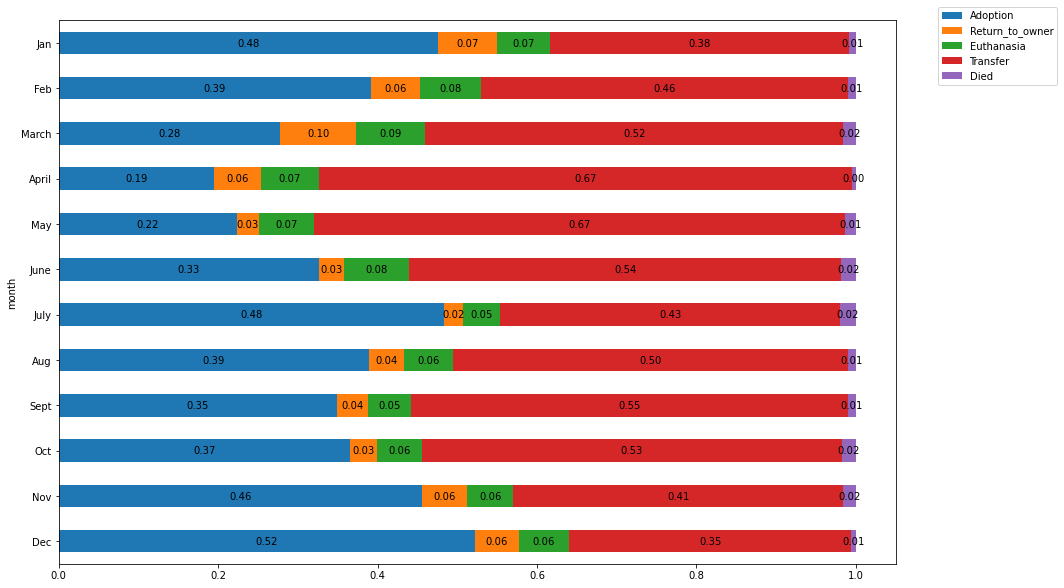

In [190]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
train[train.Dog==0].groupby('month').outcometype.value_counts(normalize=True).unstack()\
.loc[['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec'][::-1]].T\
.loc[['Adoption','Return_to_owner','Euthanasia','Transfer','Died']].T.plot(kind='barh', stacked=True, ax=ax)
ax.legend(loc=(1.05,0.88),labels=['Adoption','Return_to_owner','Euthanasia','Transfer','Died'])

for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2

        if label_x >= max_width*.05:
            ax.text(label_x, label_y, f'{label_text:.2f}'
                    , ha='center', va='center', color = 'black')

In [191]:
train.drop('datetime', axis=1, inplace=True)
test.drop('datetime', axis=1, inplace=True)

In [192]:
train.to_csv('train_eda.csv', index=False)
test.to_csv('test_eda.csv', index=False)